# Importing Libraries

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Available Device is: ", device)

c:\Users\rk\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available Device is:  cuda


# Loading Data

In [2]:
df = pd.read_json("news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
print(df.shape)
df.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
df.drop("article_link", inplace=True, axis=1)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


# Data Splitting

In [4]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df["headline"]), np.array(df["is_sarcastic"]), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [5]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(18696,)
(4007,)
(4006,)


# Importing pre trained Model

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

# Custom Class Dataset

In [7]:
class dataset(Dataset):
    def __init__(self, X, Y):
        self.X = [tokenizer(x,
                            max_length=100,
                            truncation=True,
                            padding='max_length',
                            return_tensors='pt').to(device)
                  for x in X]
        self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

# Hyperparameters

In [8]:
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4

# DataLoader

In [9]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [10]:
class MyModel(nn.Module):
    def __init__(self, bert):
        super(MyModel, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.25)
        self.linear1 = nn.Linear(768, 384)
        self.linear2 = nn.Linear(384, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids, attention_mask, return_dict=False)[0][:, 0]
        output = self.linear1(pooled_output)
        output = self.dropout(output)
        output = self.linear2(output)
        output = self.sigmoid(output)
        return output

### Freezing bert parameters

In [11]:
for param in bert_model.parameters():
    param.requires_grad = False

model = MyModel(bert_model).to(device)

# Loss and Optimizer

In [12]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=LR)

# Model Training and Validation

In [13]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    model.train()
    for indx, data in enumerate(train_dataloader):
        input, label = data
        input.to(device)
        label.to(device)

        prediction = model(input['input_ids'].squeeze(1),
                           input['attention_mask'].squeeze(1)).squeeze(1)

        batch_loss = criterion(prediction, label)
        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == label).sum().item()
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        for indx, data in enumerate(validation_dataloader):
            input, label = data
            input.to(device)
            label.to(device)

            prediction = model(input['input_ids'].squeeze(1),
                               input['attention_mask'].squeeze(1)).squeeze(1)

            batch_loss_val = criterion(prediction, label)
            total_loss_val += batch_loss_val.item()

            acc = ((prediction).round() == label).sum().item()
            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_validation_plot.append(round(total_loss_val / 100, 4))
    total_acc_train_plot.append(round(total_acc_train / training_data.__len__() * 100, 4))
    total_acc_validation_plot.append(round(total_acc_val / validation_data.__len__() * 100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train / 1000:.4f} Train Accuracy: {(total_acc_train / training_data.__len__()) * 100:.4f} Validation Loss: {total_loss_val / 100:.4f} Validation Accuracy: {(total_acc_val / validation_data.__len__()) * 100:.4f}''')
    print("=" * 50)


Epoch no. 1 Train Loss: 0.2787 Train Accuracy: 78.8297 Validation Loss: 0.5049 Validation Accuracy: 82.7259
Epoch no. 2 Train Loss: 0.2382 Train Accuracy: 82.2475 Validation Loss: 0.4602 Validation Accuracy: 84.1238
Epoch no. 3 Train Loss: 0.2270 Train Accuracy: 82.7985 Validation Loss: 0.4423 Validation Accuracy: 84.6730
Epoch no. 4 Train Loss: 0.2235 Train Accuracy: 83.5152 Validation Loss: 0.4374 Validation Accuracy: 84.8477
Epoch no. 5 Train Loss: 0.2212 Train Accuracy: 83.4884 Validation Loss: 0.4323 Validation Accuracy: 84.8727
Epoch no. 6 Train Loss: 0.2208 Train Accuracy: 83.6596 Validation Loss: 0.4335 Validation Accuracy: 84.8477
Epoch no. 7 Train Loss: 0.2179 Train Accuracy: 83.8308 Validation Loss: 0.4541 Validation Accuracy: 84.1737
Epoch no. 8 Train Loss: 0.2173 Train Accuracy: 83.8415 Validation Loss: 0.4168 Validation Accuracy: 85.4468
Epoch no. 9 Train Loss: 0.2170 Train Accuracy: 83.9538 Validation Loss: 0.4349 Validation Accuracy: 84.7978
Epoch no. 10 Train Loss: 0.2

# Visualization

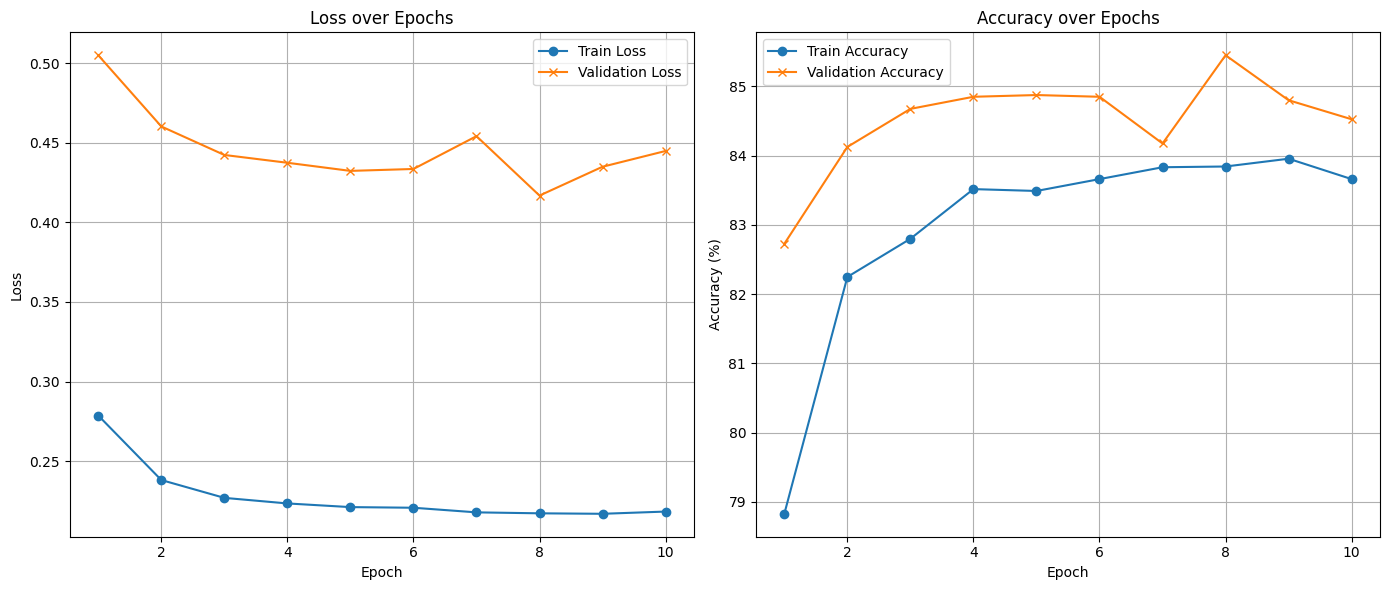

In [14]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, total_loss_train_plot, label='Train Loss', marker='o')
plt.plot(epochs, total_loss_validation_plot, label='Validation Loss', marker='x')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, total_acc_train_plot, label='Train Accuracy', marker='o')
plt.plot(epochs, total_acc_validation_plot, label='Validation Accuracy', marker='x')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Testing and Evaluation

In [16]:
model.eval()  
total_acc_test = 0
total_loss_test = 0

with torch.no_grad():
    for indx, data in enumerate(testing_dataloader):
        input, label = data
        input = {key: val.to(device) for key, val in input.items()}  # move both ids & mask
        label = label.to(device)

        prediction = model(
            input['input_ids'].squeeze(1),
            input['attention_mask'].squeeze(1)
        ).squeeze(1)

        batch_loss = criterion(prediction, label)
        total_loss_test += batch_loss.item()

        acc = ((prediction).round() == label).sum().item()
        total_acc_test += acc

# Calculate averages
avg_loss = total_loss_test / len(testing_dataloader)
avg_acc = (total_acc_test / testing_data.__len__()) * 100

print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {avg_acc:.2f}%")

Test Loss: 0.3323
Test Accuracy: 85.87%


______________________________